In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import missingno as msno
from sklearn.cluster import DBSCAN

from sklearn.datasets import make_blobs
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

## 0. Configuration Parameters
Customizing constants for the run(s).

In [3]:
# config
np.random.seed(2123)

## 1. Datasets

### 1.0. Create or load dataset
As of now, only a toy dataset is used (3 features with 3 clusters centered around different points).

In [8]:
features, clusters = make_blobs(n_samples=[50, 100, 50],
                                centers=[[1, 5, 1], [7, 12, 9], [10, 2, 5]],
                                n_features=3,
                                cluster_std=1.5, )

### 1.1. plot data

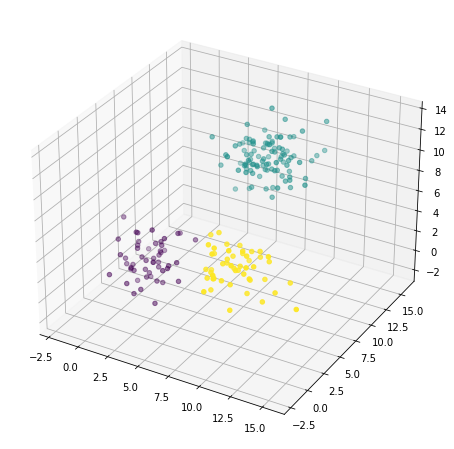

In [6]:
# plot dataset
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=clusters)
plt.show()

### 1.4. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [35]:
# name feature and cluster (ground truth) columns
features = pd.DataFrame(features, columns=[f"F{x + 1}" for x in range(features.shape[1])])
clusters = pd.DataFrame(clusters, columns=["C"])

# create missing values in feature column(s)
mv_percent = [0, 0, 10]  # percentages of missing values created in the feature columns
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), mv_percent)}

features_mv = features.copy()
for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv / 100)

#### plot missing values.

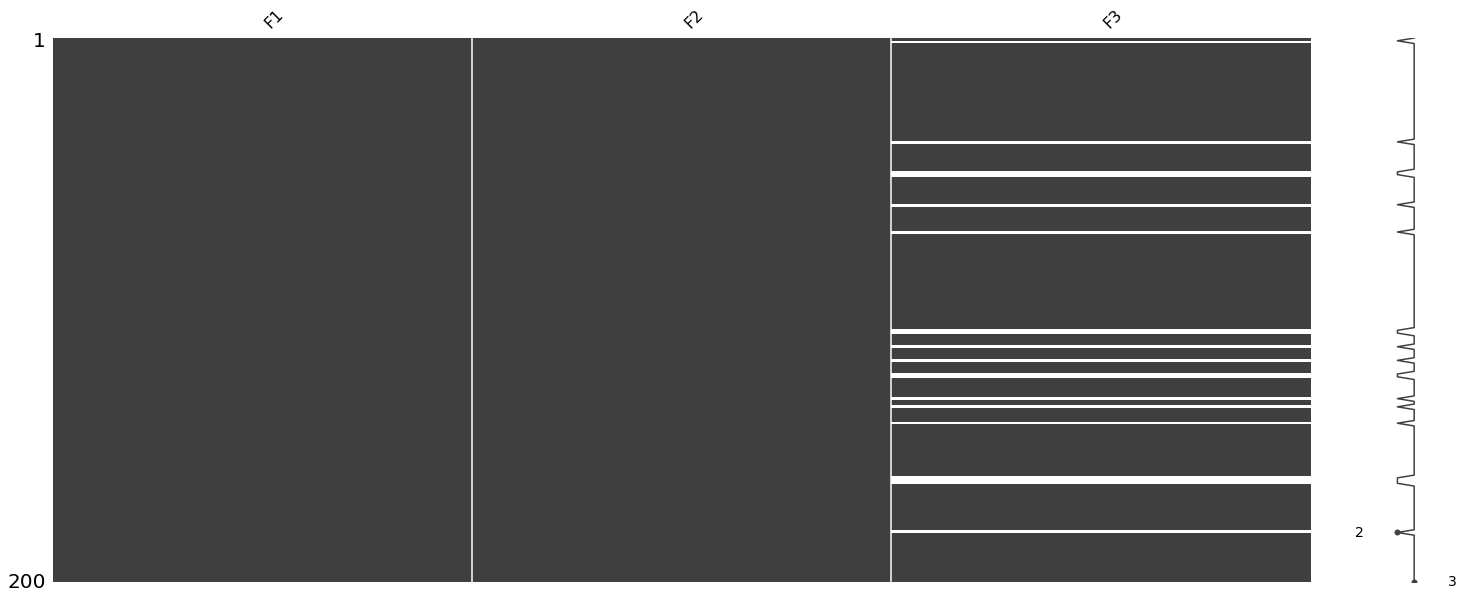

In [36]:
msno.matrix(features_mv)
plt.show()

## 2. Filling Strategies
Fill missing values (here with TabNet).
Currently only working, if Feature F3 has missing values (and F1, F2 complete). The TabNet Pretrainer might work to fill all missing values in different features.

In [37]:
# use TabNet to predict missing values
test = features_mv[features_mv["F3"].isna()].drop("F3", axis=1).to_numpy()
train = features_mv[features_mv["F3"].notna()]
train_features = train.iloc[:, :-1].to_numpy()
train_target = train.iloc[:, -1].to_numpy().reshape(-1, 1)

x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)

model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                        optimizer_params=dict(lr=2e-2),
                        scheduler_params={"step_size": 50, "gamma": 0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type='entmax')

model.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric=['rmse'],
    max_epochs=1000, patience=50,
)

Device used : cpu
epoch 0  | loss: 30.89104| val_0_rmse: 101.88895|  0:00:00s
epoch 1  | loss: 18.73516| val_0_rmse: 153.63413|  0:00:00s
epoch 2  | loss: 10.79903| val_0_rmse: 62.67197|  0:00:00s
epoch 3  | loss: 6.84433 | val_0_rmse: 63.37417|  0:00:00s
epoch 4  | loss: 4.78668 | val_0_rmse: 59.85622|  0:00:00s
epoch 5  | loss: 3.91643 | val_0_rmse: 51.90815|  0:00:00s
epoch 6  | loss: 3.20639 | val_0_rmse: 37.13191|  0:00:00s
epoch 7  | loss: 3.25681 | val_0_rmse: 28.12817|  0:00:00s
epoch 8  | loss: 2.87553 | val_0_rmse: 17.96646|  0:00:00s
epoch 9  | loss: 2.80111 | val_0_rmse: 15.95601|  0:00:00s
epoch 10 | loss: 2.69538 | val_0_rmse: 14.08013|  0:00:00s
epoch 11 | loss: 2.52845 | val_0_rmse: 13.0046 |  0:00:00s
epoch 12 | loss: 2.40813 | val_0_rmse: 12.82919|  0:00:00s
epoch 13 | loss: 2.25139 | val_0_rmse: 12.72436|  0:00:00s
epoch 14 | loss: 2.17159 | val_0_rmse: 12.07096|  0:00:00s
epoch 15 | loss: 2.08689 | val_0_rmse: 10.90701|  0:00:00s
epoch 16 | loss: 2.05544 | val_0_rms

epoch 145| loss: 0.55251 | val_0_rmse: 2.55931 |  0:00:04s
epoch 146| loss: 0.53664 | val_0_rmse: 2.52584 |  0:00:04s
epoch 147| loss: 0.57652 | val_0_rmse: 2.45629 |  0:00:04s
epoch 148| loss: 0.55775 | val_0_rmse: 2.47417 |  0:00:04s
epoch 149| loss: 0.51901 | val_0_rmse: 2.58972 |  0:00:04s
epoch 150| loss: 0.5651  | val_0_rmse: 2.56839 |  0:00:05s
epoch 151| loss: 0.55935 | val_0_rmse: 2.45871 |  0:00:05s
epoch 152| loss: 0.5565  | val_0_rmse: 2.4219  |  0:00:05s
epoch 153| loss: 0.54899 | val_0_rmse: 2.43887 |  0:00:05s
epoch 154| loss: 0.49839 | val_0_rmse: 2.43095 |  0:00:05s
epoch 155| loss: 0.50146 | val_0_rmse: 2.35096 |  0:00:05s
epoch 156| loss: 0.51591 | val_0_rmse: 2.3384  |  0:00:05s
epoch 157| loss: 0.49465 | val_0_rmse: 2.34886 |  0:00:05s
epoch 158| loss: 0.50224 | val_0_rmse: 2.28357 |  0:00:05s
epoch 159| loss: 0.4824  | val_0_rmse: 2.21223 |  0:00:05s
epoch 160| loss: 0.50699 | val_0_rmse: 2.1935  |  0:00:05s
epoch 161| loss: 0.48953 | val_0_rmse: 2.22671 |  0:00:0

## 3. Complete Dataset

In [30]:
# fill original dataset with predictions
features_filled = features_mv.copy()
features_filled[features_filled["F3"].isna()] = model.predict(test)

## 4. Clustering

In [31]:
# apply clustering
dbscan = DBSCAN(eps=2, min_samples=10).fit(features_filled)
clusters_filled = dbscan.labels_

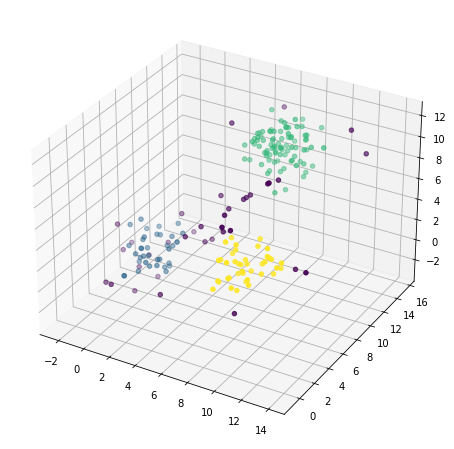

In [32]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_filled.iloc[:, 0], features_filled.iloc[:, 1], features_filled.iloc[:, 2], c=clusters_filled)
plt.show()

## 5. Cluster Performance
to be implemented